project name: flexpart_management
created by diego aliaga daliaga_at_chacaltaya.edu.bo

imports

In [1]:

from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import matplotlib.colors
import flexpart_management.modules.FlexLogPol as FlexLogPol
import flexpart_management.modules.constants as co
# noinspection PyUnresolvedReferences
import flexpart_management.modules.flx_array as fa

Loading BokehJS ...

reload


In [2]:
import flexpart_management.modules.clustering_funs as cfuns
from flexpart_management.modules.clustering_funs import (
    add_total_per_row ,
    add_time_per_row ,
    )

# import flexpart_management.modules.clustering_funs as cfuns
def main():
    # plt.rcParams[ 'figure.facecolor' ] = 'white'
    co.LAB = 'lab'

    # plt.style.use('seaborn-whitegrid')
    # plt.rcParams["legend.frameon"] = True
    # plt.rcParams["legend.fancybox"] = True

    # %%
    # def main() :

    log.ger.setLevel( log.log.DEBUG )

    # %%
    # noinspection PyUnusedLocal,PyShadowingNames
    def open_if_taito() :
                     # noinspection SpellCheckingInspection
                     path = \
                     '/homeappl/home/aliagadi/wrk/DONOTREMOVE' \
                     '/flexpart_management_data/runs/' \
                     'run_2019-10-02_13-42-52_/' \
                     'log_pol/run_2019-10-02_13-42-52_'
                     # flp = FLP.FlexLogPol(path,concat=True)
                     # flp_instance = FLP.FlexLogPol(path,concat=False)
                     selfFLP = FlexLogPol.FlexLogPol(
                     path ,
                     # concat=True,
                     concat=False ,
                     get_clusters=False ,
                     # open_merged=False,
                     open_merged=True ,
                     # merge_ds=False ,
                     # merge_ds=True ,
                     clusters_avail=False ,

                     # postprocess set to false since we are opening the re interpolated
                     # version
                     postprocess=False ,

                     use_new_merge_fun=True ,

                     # set to false bc already done in the saved version
                     filter_r_min_max=False ,
                     )
                     selfFLP.get_list_datasets_saved()
                     # noinspection PyUnresolvedReferences
                     ds = selfFLP.open_ds_version( 'ds_clustered_18.nc' )
                     return selfFLP , ds


    # %%
    # selfFLP,ds = open_if_taito()
    path = '/Users/diego/flexpart_management/flexpart_management/tmp_data' \
       '/ds_clustered_18.nc'
    ds = xr.open_dataset( path )
    # %%
    # %%
    # %%
    conc_lab = 'CONC_smooth_t_300_z_25_r_100_th_50'
    new_lab_p = 'conc_smooth_p'
    new_lab_p_t = 'conc_smooth_p_t'
    add_total_per_row( ds , conc_lab , new_lab_p )
    add_time_per_row( ds , conc_lab , new_lab_p_t )
    # print( da_tot )

    # %%
    # ds[new_lab_p].sum([co.RL,co.ZM],keep_attrs=True).plot()
    # plt.show()
    # ds[new_lab_p_t].sum(fa.get_dims_complement(ds,co.RL),keep_attrs=True).plot()
    # plt.show()
    # %%
    prop_df = pd.read_csv(co.prop_df_path)
    prop_df
    # %%
    conc_tot_ts = 'CONC_tot_ts'
    dim_complement_rl = fa.get_dims_complement(ds['CONC'], co.RL)
    da_tot_ts = ds['CONC'].sum(dim_complement_rl) / 100
    # %%
    ranges = ('SR','SM','MR','LR')
    range_names = ('short range','short-medium range',
                  'medium range', 'long range')
    ri = 0
    for ri in range(len(ranges)):
        plot_multi_time_series(
            da_tot_ts, dim_complement_rl, ds, prop_df, ranges, range_names, ri,
            save=True
        )

    # %%
    # %%
    ddf = pd.DataFrame([])
    for l,r in prop_df.iterrows():
        i = r['cluster_i']
        da_lab = ds['CONC'].where(ds['lab'] == i).sum(
            dim_complement_rl) / da_tot_ts
        ddf[r['short_name']]=da_lab.reset_coords(drop=True).to_dataframe()['CONC']

    # %%
    pdf_example_name = 'example_srr_pc_n3.pdf'
    i = 3
    plot_example(ddf, i, pdf_example_name)

    # pdf_example_name = 'example_srr_pc_n3.pdf'
    # i = 18
    # plot_example(ddf, i, pdf_example_name)

    # %%

    # %%


def plot_example(ddf, i, pdf_example_name):
    f, ax = plt.subplots(1, 1, figsize=(4, 2.5))
    new_df = ddf.iloc[::50, -i:].copy() + 1
    new_df.columns = ['cluster 1', 'cluster 2', 'cluster 3']
    new_df: pd.DataFrame
    new_df = new_df.rolling(10, min_periods=1, center=True,
                            win_type='gaussian').mean(std=3)
    df_sum = new_df.sum(axis=1)
    new_dfn = (new_df.T / df_sum).T * 100
    new_dfn.plot.area(ax=ax)
    ax.legend(ncol=len(new_df.columns), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    ax.set_ylim(0, 100)
    ax.set_xlabel('arrival time')
    ax.set_ylabel(r'${SRR}_{pc}$')
    ax.set_title('Example of ${SRR}_{pc}$ for $n=3$ clusters \n\n')
    f.tight_layout()
    plt.show()
    path = '/Users/diego/flexpart_management/flexpart_management/victoria_trento/figures'
    f.savefig(os.path.join(path, pdf_example_name))

In [3]:

def plot_multi_time_series(da_tot_ts, dim_complement_rl, ds, prop_df, ranges,
                           range_names, ri, save=False):
    prop_df_ = prop_df[prop_df['range'] == ranges[ri]]
    col = ucp.cc[ri]
    len_df = len(prop_df_)
    f, axs = plt.subplots(len_df, sharex=True, sharey=True,
                          figsize=(4, .8 * len_df+.5))
    axf = axs.flatten()
    for ii, (l, r) in enumerate(prop_df_.iterrows()):
        i = r['cluster_i']
        da_lab = ds['CONC'].where(ds['lab'] == i).sum(
            dim_complement_rl) / da_tot_ts

        # cfuns.plot_lab_time_series(da_lab=da_lab)
        df_lab = da_lab.reset_coords(drop=True).to_dataframe()
        ax: plt.Axes = axf[ii]
        df_lab['CONC'].plot(ax=ax, c=col)
        # ax.grid(linestyle=':')
        # ax.set_xlabel(None)
        ax.annotate(r['short_name'],(1,1),xycoords='axes fraction',
                    verticalalignment='top',xytext=(-2,-2),
                    horizontalalignment='right',
                    textcoords='offset points'
                    )
        if ii is 0:
            ax.set_title(range_names[ri])

    ax.set_ylabel('SRR [%]')

    f.tight_layout()
    # f.suptitle(range_names[ri])
    #
    ax.annotate('SRR [%]',(0.03,.5),rotation=90,xycoords='figure fraction',
                horizontalalignment = 'left',
                verticalalignment='center'
                )
    ax.set_ylabel(None)
    # f.tight_layout()
    #
    # ax.annotate('release time',(0.5,.01),rotation=0,
    #             xycoords='figure fraction',
    #             horizontalalignment = 'center'
    #             )
    #
    # ax.annotate(range_names[ri],(0.5,1),rotation=0,
    #             xycoords='figure fraction',
    #             horizontalalignment = 'center',
    #             verticalalignment='top'
    #             )
    # f.subplots_adjust(left=.1)


    f:plt.Figure
    # f.suptitle()
    plt.show()
    if save:
        path = '/Users/diego/flexpart_management/flexpart_management/victoria_trento/figures'
        name = ranges[ri]+'time_series'+'.pdf'
        f.savefig(os.path.join(path,name))

# plot_multi_time_series(da_tot_ts, dim_complement_rl, ds, prop_df, ranges,range_names, 3)

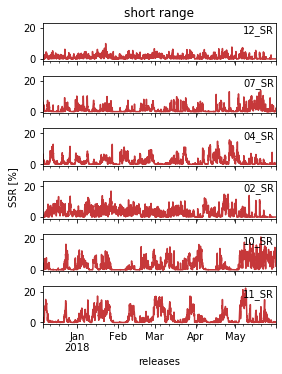

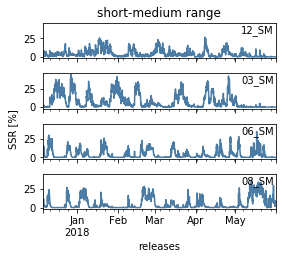

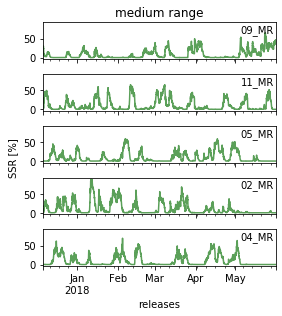

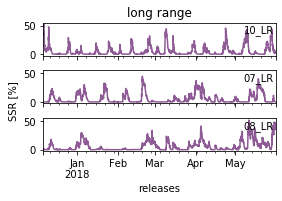

/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


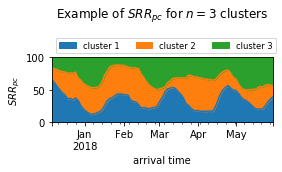

In [4]:

main()